In [127]:
import glob
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


In [128]:
args={}
kwargs={}
args['batch_size']=64
args['test_batch_size']=64
args['epochs']=40  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=100 // args['batch_size']
args['cuda']=False


In [129]:
#load npy files
train_dataset = np.load('trainset.npy')
train_label = np.load('trainlabel.npy')
test_dataset = np.load('testset.npy')

print(train_dataset.shape)


(50000, 32, 32, 3)


In [130]:
train_data=[]
for idx, data in enumerate(train_dataset):
    train_data.append([data,train_label[idx]])

In [131]:
# Function: Split Data
def shuffle_train_valid_split(X, test_size=0.2, shuffle=True, random_state=1004):
    test_num = int(len(X) * test_size)
    train_num = len(X) - test_num
    
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(X)
        X_train = X[:train_num]
        X_valid = X[train_num:]
    else:
        X_train = X[:train_num]
        X_valid = X[train_num:]
        
    return X_train, X_valid

In [132]:
train_data, valid_data = shuffle_train_valid_split(train_data)

print(len(train_data))

40000


In [133]:
#custom dataset 
class CustomDataset(Dataset):
    def __init__(self, input, transform=None):
        super().__init__()
        self.x_data = [data[0] for data in input]
        self.y_data = [data[1] for data in input]
        self.transform = transform 

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        if self.transform:
            x = self.transform(x)

        return x, y
        

In [134]:
#custom dataset 
class testDataset(Dataset):
    def __init__(self, input, transform=None):
        super().__init__()
        self.x_data =input
        self.transform = transform 

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        if self.transform:
            x = self.transform(x)

        return x
        

In [135]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [136]:
traindata = CustomDataset(train_data, transform=transform_train)
validdata = CustomDataset(valid_data, transform=transform_test)
testdata = testDataset(test_dataset, transform=transform_test)

#data loader
train_loader = DataLoader(traindata, batch_size=64, shuffle=True)
valid_loader = DataLoader(validdata, batch_size=64, shuffle=True)
test_loader = DataLoader(testdata, batch_size=64, shuffle=False)


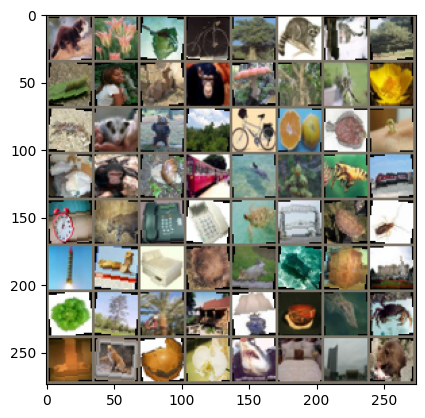

In [137]:
# Check DataLoader
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(train_loader))
out = make_grid(inputs)

imshow(out)

In [138]:
#32*32*3 convolutional neural network (two convolutional layers)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x




In [139]:
for batch, (X,y)in enumerate(train_loader):
    print(batch)
    print(X.shape)
    print(y.shape)
    break

0
torch.Size([64, 3, 32, 32])
torch.Size([64])


In [140]:

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 128 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct



In [141]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = Net().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

Using cpu device


In [142]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

63092

In [143]:

base_correct = 0
for t in range(args['epochs']):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    correct = test_loop(valid_loader, model, loss_fn)
    if correct > base_correct:
        print('save model')
        torch.save(model.state_dict(), 'model2.pt')
        base_correct = correct
print("Done!")

Epoch 1
-------------------------------
loss: 4.609321  [    0/40000]
loss: 4.477179  [ 8192/40000]
loss: 4.067835  [16384/40000]
loss: 4.237401  [24576/40000]
loss: 3.628115  [32768/40000]
Test Error: 
 Accuracy: 12.2%, Avg loss: 3.826410 

save model
Epoch 2
-------------------------------
loss: 3.683396  [    0/40000]
loss: 3.832478  [ 8192/40000]
loss: 3.594978  [16384/40000]
loss: 3.735421  [24576/40000]
loss: 3.315897  [32768/40000]
Test Error: 
 Accuracy: 16.6%, Avg loss: 3.584581 

save model
Epoch 3
-------------------------------
loss: 3.417095  [    0/40000]
loss: 3.654185  [ 8192/40000]
loss: 3.217859  [16384/40000]
loss: 3.258379  [24576/40000]
loss: 3.530532  [32768/40000]
Test Error: 
 Accuracy: 18.9%, Avg loss: 3.451418 

save model
Epoch 4
-------------------------------
loss: 3.543383  [    0/40000]
loss: 2.963159  [ 8192/40000]
loss: 3.304149  [16384/40000]
loss: 3.323394  [24576/40000]
loss: 3.301119  [32768/40000]
Test Error: 
 Accuracy: 20.8%, Avg loss: 3.355005 


In [ ]:
import csv
def test(dataloader, model):
    idx = 0
    result = []
    model.eval()
    with torch.no_grad():
        for X in dataloader:
            X = X.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)

            try:
                for i in range(batch):
                    result.append([idx,predicted[i].item()])
                    idx+=1
            except:
                pass
    return result

model.load_state_dict(torch.load('model2.pt'))
result = test(test_loader,model)
fields = ['id_idx','label']
with open('result.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(fields)
    writer.writerows(result)